In [4]:
#COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0]]

#CLASSES = ['fondo', 'botella', 'celular']

#def colormap2label():
#    colorlabel = torch.zeros(256 ** 3, dtype=torch.long)
#    for i, colormap in enumerate(COLORMAP):
#        colorlabel[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
#    return colorlabel

#def label_indices(colormap, colorlabel):
#    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
#    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
#    return colorlabel[idx]

In [3]:
#import torch
#import torchvision
#import os 

#archivos =[archivo.split('.')[0] for archivo in os.listdir('./DataSet/MascarasOriginales')]

#imagenes_ori, mascaras_ori = [], []
#for archivo in archivos:
#    imagenes_ori.append(torchvision.io.read_image('./DataSet/ImagenesOriginales/'+archivo+'.jpg'))
#    mascaras_ori.append(torchvision.io.read_image('./DataSet/MascarasOriginales/'+archivo+'.png',torchvision.io.image.ImageReadMode.RGB))

#len(imagenes_ori), len(mascaras_ori)

In [4]:
#imagenes = []
#for imagen in imagenes_ori:
#    imagenes.append(imagen.float()/255)

#colorlabel = colormap2label()
#mascaras = []
#for mascara in mascaras_ori:
#    mascaras.append(label_indices(mascara,colorlabel))

In [5]:
#import matplotlib.pyplot as plt

#fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,10))
#imagen = imagenes[0].permute(1, 2, 0)
#mascara = mascaras[0].permute(1, 2, 0)
#ax1.imshow(imagen)
#ax2.imshow(mascara)
#plt.show()

In [6]:
'''
import numpy as np

for i, imagen in enumerate(imagenes):
    np.save('./DataSet/Imagenes/'+archivos[i],imagen.numpy())

for i, mascara in enumerate(mascaras):
    np.save('./DataSet/Mascaras/'+archivos[i],mascara.numpy())
'''

In [38]:
# Para dejar únicamente las clases 0,1 y 2 de la base de datos VOC2012
#import os 
#from pathlib import Path

#path = Path('./DataSet')
#imgs = [path/'Imagenes'/i for i in os.listdir(path/'Imagenes')]
#masks = [path/'Mascaras'/i for i in os.listdir(path/'Mascaras')]

#len(imgs), len(masks)

#for mask in masks:
#    mascara=np.load(mask)
#    print(mask)
#    for c in range(0,320):
#        for f in range(0,480):
#            if mascara[c][f]>2:
#                print(mascara[c][f])
#                mascara[c][f]=0
#    np.save(mask,mascara)


In [3]:
import torch
import os 
from pathlib import Path

# El alto y ancho de las imágenes debe ser divisible por 16 para que concidan las dimensiones de las capas 
# convolucionales y convolucionales transpuestas.
path = Path('./DataSet')
imgs = [path/'Imagenes'/i for i in os.listdir(path/'Imagenes')]
masks = [path/'Mascaras'/i for i in os.listdir(path/'Mascaras')]

len(imgs), len(masks)

(26, 26)

(3, 480, 640)


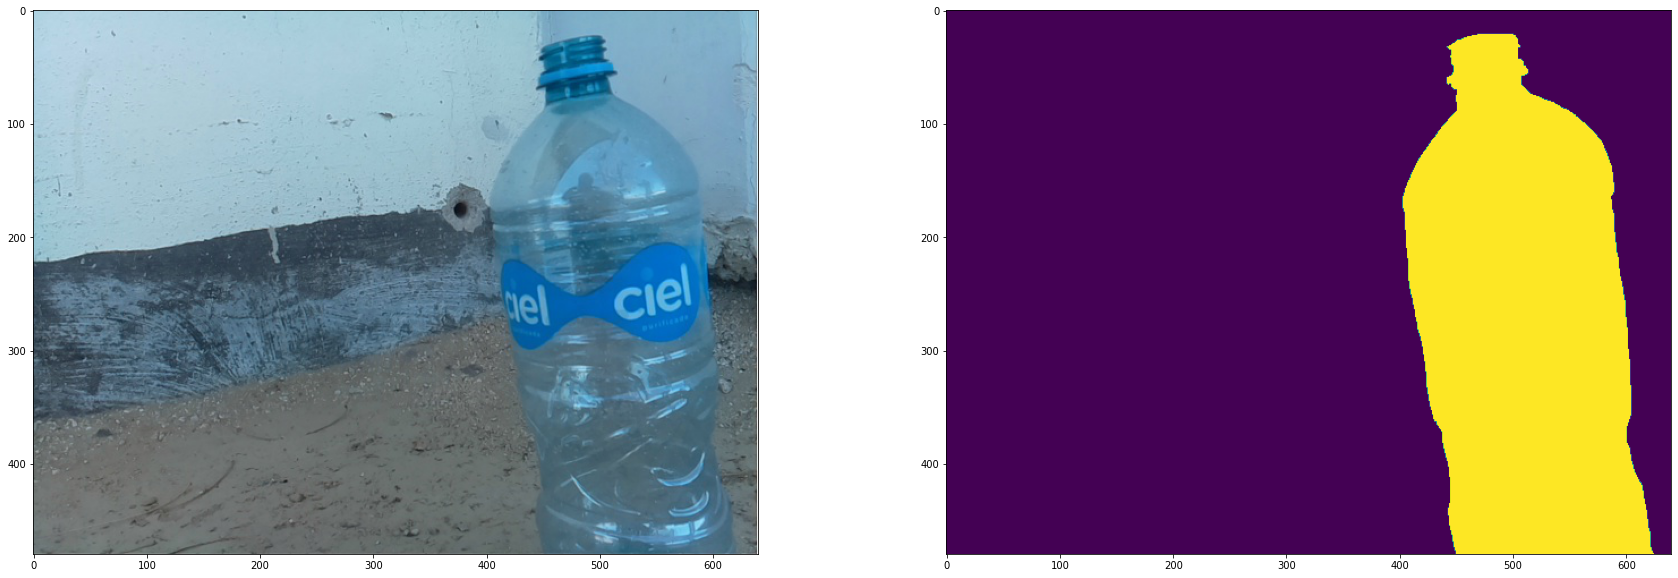

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(torch.from_numpy(img).permute(1,2,0).numpy())
ax2.imshow(mask)
print(img.shape)
plt.show()

In [4]:
import numpy as np
import torchvision 
#escalar = torchvision.transforms.Resize((394,394)) Para el caso en que las imagenes tengan que escalarse

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    #img = escalar(torch.from_numpy(img)).numpy() Para el caso en que las imagenes tengan que escalarse
    mask = np.load(self.y[ix])
    #mask = escalar(torch.from_numpy(mask).unsqueeze(dim=0)).squeeze(dim=0).numpy() Para el caso en que las imagenes tengan que escalarse
    #img = torch.tensor(img).unsqueeze(0) Para el caso donde se trabaje con un solo canal
    img = torch.tensor(img) # Se intercambia con la línea anterior, dependiendo si es un solo canal o tres canales (este es para tres canales) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [5]:
dataset = {
    'train': Dataset(imgs[:-5], masks[:-5]),
    'test': Dataset(imgs[-5:], masks[-5:])
}

len(dataset['train']), len(dataset['test'])

(21, 5)

In [6]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=5, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 480, 640]), torch.Size([5, 3, 480, 640]))

In [7]:
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [8]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [9]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [10]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=10)

test_loss 0.70774 test_iou 0.04288: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 1/10 loss 0.67764 iou 0.37625 test_loss 0.70774 test_iou 0.04288


test_loss 0.69280 test_iou 0.17968: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 2/10 loss 0.57200 iou 0.68382 test_loss 0.69280 test_iou 0.17968


test_loss 0.67300 test_iou 0.60662: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 3/10 loss 0.51508 iou 0.78142 test_loss 0.67300 test_iou 0.60662


test_loss 0.81134 test_iou 0.49668: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 4/10 loss 0.48007 iou 0.85813 test_loss 0.81134 test_iou 0.49668


test_loss 0.60434 test_iou 0.67167: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 5/10 loss 0.45997 iou 0.85781 test_loss 0.60434 test_iou 0.67167


test_loss 0.53216 test_iou 0.86357: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 6/10 loss 0.44320 iou 0.88921 test_loss 0.53216 test_iou 0.86357


test_loss 0.48459 test_iou 0.85151: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 7/10 loss 0.42711 iou 0.92579 test_loss 0.48459 test_iou 0.85151


test_loss 0.44328 test_iou 0.88268: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 8/10 loss 0.41787 iou 0.89217 test_loss 0.44328 test_iou 0.88268


test_loss 0.41728 test_iou 0.87993: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 9/10 loss 0.40442 iou 0.90592 test_loss 0.41728 test_iou 0.87993


test_loss 0.39876 test_iou 0.87866: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch 10/10 loss 0.39174 iou 0.93470 test_loss 0.39876 test_iou 0.87866


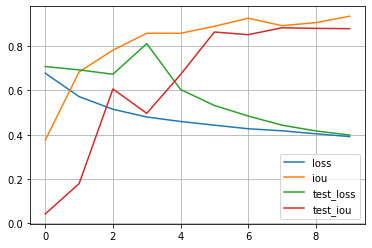

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [46]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['train'])-1)
    print(ix)
    img, mask = dataset['train'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
print(img.shape)
print(mask.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

4
torch.Size([3, 480, 640])
torch.Size([3, 480, 640])


KeyboardInterrupt: 